### Import

In [14]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import math
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

## Leitura do ficheiro

In [15]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [16]:
file = data_folder / "QuebrasJuntoInc.xlsx"
QuebrasFinal = pd.read_excel(file)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55,828,"0,0029345","0,0000443","0,0024563",...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163,549,"0,0029335","0,0001770","0,0165009",...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596,3459,"0,0192281","0,0002655","0,0359047",...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178,102,"0,0000000","0,0000000","0,0000000",...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119,1731,"0,0044221","0,0001549","0,0100377",...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220,2,0,0,0,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7724,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92,1,0,0,0,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7725,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121,1,0,0,0,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7726,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154,1,0,0,0,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


In [17]:
QuebrasFinal["Ano"].unique()

array([2018, 2021, 2022, 2023, 2019, 2020, 2014, 2015, 2016, 2017])

## Breve tratamento dos dados

In [18]:
# Remover colunas desnecessárias
columnsRemove = ['Qualidade de Energia Elétrica', 'Qualidade de Serviço Comercial', 'Fundamentação']
QuebrasFinal = QuebrasFinal.drop(columns=columnsRemove)

# Substituir as vírgulas por pontos nas colunas supostamente numéricas
colunas_string = QuebrasFinal.iloc[:, 5:33].select_dtypes(include=['object']).columns
QuebrasFinal[colunas_string] = QuebrasFinal[colunas_string].replace(',', '.', regex=True)

# Lista das colunas a serem convertidas
colunas_para_converter = ['Duração incidente (min)', 'TIEPI MT (min)', 'SAIFI MT (#)', 
                          'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)', 'SAIDI BT (min)', 'N.º clientes afetados']

# Converter as colunas para o tipo float
QuebrasFinal[colunas_para_converter] = QuebrasFinal[colunas_para_converter].apply(pd.to_numeric, errors='coerce')
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7723,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7724,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7725,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1
7726,EDPD_2017_NOV_T_65,Almeirim,2017-11-03,BT,Descarga Atmosférica Directa,154.0,1.0,0.000000,0.000000,0.000000,...,175.1,1.000000,15.0,20.8,12.8,186.0,186.0,2.5,11.0,NaN


### Criação de variáveis

In [19]:
QuebrasFinal = QuebrasFinal[(QuebrasFinal["Nível de Tensão"] == "BT") | (QuebrasFinal["Nível de Tensão"] == "MT")].reset_index(drop=True)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Indice de Envelhecimento,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,157.9,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,260.2,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,117.9,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,156.4,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,467.9,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.000000,0.000000,0.000000,...,119.8,0.000000,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,141.7,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,134.6,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,134.6,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1


### Tipos de tensão

In [20]:
QuebrasFinal["Ser_BT?"] = np.where(QuebrasFinal["Nível de Tensão"] == "BT", 1, 0)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,Rural,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,0.000000,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0,0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,1.000000,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0,0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,0.800000,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0,0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,0.923077,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,1.000000,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.000000,0.000000,0.000000,...,0.000000,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3,1
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,1.000000,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0,1
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,0.000000,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN,1
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,0.000000,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1,1


### Causas

In [21]:
# Lista de categorias de causas de incidentes pertencentes a cada grande classe
humanosAcidente = ['Escavações', 'Abate De Árvores', 'Veículos', 'Incêndio', 
           'Risco Iminente Pessoas Ou Bens', 'Trabalhos De Terceiros ( Gruas,... )', 
           'Intervenções À Superficie', 'Desabamento De Muros/Outras Construções', 
         'Ruptura De Canal. De Fluídos', 'Desabamento De Muros/Outras Cons']

humanosIntenção = ['Malfeitorioa (Vandalismo)', 'Malfeitoria/Vandalismo', 'Furtos', 'Sabotagem',]

animais = ['Aves', 'Animais Não Aves', 'Corpos Estranhos Na Rede']

clima = ['Deslizamento De Terras', 'Terramoto', 'Neve/Gelo/Granizo Condição Excecional', 
         'Vento Intensidade Excepcional', 'Descarga Atmosférica Directa',  
         'Inundações Imprevisíveis']

# Função para atribuir a classe correspondente com base na causa do incidente
def assign_class(cause):
    if cause in humanosAcidente:
        return 'Humanos - Acidentes'
    elif cause in humanosIntenção:
        return 'Humanos - Intenção'
    elif cause in animais:
        return 'Animais'
    elif cause in clima:
        return 'Clima'
    else:
        return 'Outros'

# Criar uma nova coluna com as classes atribuídas
QuebrasFinal['Grande Classe'] = QuebrasFinal['Causa do incidente'].apply(assign_class)
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,T_MED,T_MAX,T_MIN,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Grande Classe
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,10.7,17.4,2.6,NaN,NaN,NaN,NaN,0.0,0,Humanos - Acidentes
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,10.6,13.8,6.2,249.0,270.0,2.8,8.1,0.0,0,Humanos - Acidentes
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,14.0,14.8,12.9,197.0,180.0,3.9,14.4,4.0,0,Clima
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,12.4,15.1,9.1,288.0,225.0,3.6,13.9,13.2,1,Humanos - Acidentes
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,4.9,7.8,2.2,137.0,118.0,4.1,15.4,15.9,0,Animais
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.000000,0.000000,0.000000,...,12.5,17.7,6.1,28.0,326.0,NaN,NaN,1.3,1,Humanos - Acidentes
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,10.3,14.3,6.3,NaN,NaN,NaN,NaN,0.0,1,Humanos - Acidentes
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,16.4,20.6,14.8,NaN,NaN,NaN,NaN,NaN,1,Humanos - Acidentes
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,17.9,22.6,14.6,NaN,NaN,NaN,NaN,8.1,1,Humanos - Acidentes


In [22]:
# Criar variáveis dummy
dummies = pd.get_dummies(QuebrasFinal["Grande Classe"])

# Converter as variáveis dummy de booleanas para int
dummies = dummies.astype(int)

# Concatenar as variáveis dummy ao DataFrame original
QuebrasFinal = pd.concat([QuebrasFinal, dummies], axis=1)

# Excluir a coluna original "Grande Classe"
QuebrasFinal.drop("Grande Classe", axis=1, inplace=True)

# Exibir o DataFrame com as variáveis dummy convertidas para int
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Clima,Humanos - Acidentes,Humanos - Intenção
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,55.0,828.0,0.002935,0.000044,0.002456,...,NaN,NaN,NaN,NaN,0.0,0,0,0,1,0
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,163.0,549.0,0.002933,0.000177,0.016501,...,249.0,270.0,2.8,8.1,0.0,0,0,0,1,0
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,596.0,3459.0,0.019228,0.000266,0.035905,...,197.0,180.0,3.9,14.4,4.0,0,0,1,0,0
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,178.0,102.0,0.000000,0.000000,0.000000,...,288.0,225.0,3.6,13.9,13.2,1,0,0,1,0
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,119.0,1731.0,0.004422,0.000155,0.010038,...,137.0,118.0,4.1,15.4,15.9,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,235.0,2.0,0.000000,0.000000,0.000000,...,28.0,326.0,NaN,NaN,1.3,1,0,0,1,0
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,220.0,2.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.0,1,0,0,1,0
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,92.0,1.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,121.0,1.0,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,8.1,1,0,0,1,0


## Estandardizar / Normalizar os dados

In [23]:
# Selecionar as colunas numéricas
colunas_numericas = QuebrasFinal.select_dtypes(include=[np.number, bool]).columns
colunas_numericas

Index(['Duração incidente (min)', 'N.º clientes afetados', 'TIEPI MT (min)',
       'SAIFI MT (#)', 'SAIDI MT (min)', 'END (MWh)', 'SAIFI BT (#)',
       'SAIDI BT (min)', 'Dia', 'Mês', 'Ano', 'Bibliotecas e Arquivos',
       'Desporto e Lazer', 'Edifícios degradados ou devolutos',
       'Espectáculos e Reuniões Públicas', 'Estacionamento de superfície',
       'Estacionamento em profundidade ou silo', 'Habitacional',
       'Hospitalares e Lares de Idosos', 'Hotelaria e Restauração',
       'Indústria, Oficina e Armazém',
       'Militar, Forças de Segurança e Forças de Socorro',
       'Museus e Galerias de Arte', 'Parque Escolar',
       'Serviços Administrativos', 'Áreas Comerciais e Gares de Transportes',
       'Ocorrências', 'MeiosTerrestres', 'Duração Minutos',
       'Densidade Populacional', 'População Residente', 'Setor Primário',
       'Setor Secundário', 'Setor Terciário', 'Indice de Envelhecimento',
       'Rural', 'T_MED', 'T_MAX', 'T_MIN', 'DD_MED', 'DD_FFX', 'FF_MED'

In [24]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    QuebrasFinal[colunas_numericas] = scaler.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal

,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Clima,Humanos - Acidentes,Humanos - Intenção
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.169607,-0.115407,-0.184842,-0.196374,-0.273450,...,NaN,NaN,NaN,NaN,-0.380373,-0.990660,-0.496437,-0.276829,0.924304,-0.487189
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.019177,-0.241403,-0.184900,0.049989,0.189097,...,0.313542,0.362382,-0.146252,-0.592647,-0.380373,-0.990660,-0.496437,-0.276829,0.924304,-0.487189
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.583935,1.072750,0.747366,0.214293,0.828144,...,-0.164608,-0.538359,0.634293,1.180868,0.143056,-0.990660,-0.496437,3.612335,-1.081895,-0.487189
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,0.001716,-0.443268,-0.352734,-0.278619,-0.354346,...,0.672155,-0.087988,0.421417,1.040113,1.346943,1.009428,-0.496437,-0.276829,0.924304,-0.487189
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.080464,0.292387,-0.099732,0.008959,-0.023763,...,-0.716320,-1.158870,0.776210,1.462379,1.700257,-0.990660,2.014355,-0.276829,-1.081895,-0.487189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,0.081109,-0.488428,-0.352734,-0.278619,-0.354346,...,-1.718598,0.922844,NaN,NaN,-0.210259,1.009428,-0.496437,-0.276829,0.924304,-0.487189
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.060216,-0.488428,-0.352734,-0.278619,-0.354346,...,NaN,NaN,NaN,NaN,-0.380373,1.009428,-0.496437,-0.276829,0.924304,-0.487189
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118071,-0.488879,-0.352734,-0.278619,-0.354346,...,NaN,NaN,NaN,NaN,NaN,1.009428,-0.496437,-0.276829,0.924304,-0.487189
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.077678,-0.488879,-0.352734,-0.278619,-0.354346,...,NaN,NaN,NaN,NaN,0.679571,1.009428,-0.496437,-0.276829,0.924304,-0.487189


## Imputação dos dados

In [25]:
# Criar o objeto do imputador por regressão
imputer_mice = IterativeImputer()

# Aplicar o método MICE para imputar os valores ausentes em todas as colunas numéricas
QuebrasFinal[colunas_numericas] = imputer_mice.fit_transform(QuebrasFinal[colunas_numericas])

# Resultado final
QuebrasFinal


/usr/local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Código do Relatório,Concelho,Data do incidente,Nível de Tensão,Causa do incidente,Duração incidente (min),N.º clientes afetados,TIEPI MT (min),SAIFI MT (#),SAIDI MT (min),...,DD_MED,DD_FFX,FF_MED,FF_MAX,PR_QTD,Ser_BT?,Animais,Clima,Humanos - Acidentes,Humanos - Intenção
0,EDPD_2018_JAN_T_1,Almada,2018-01-02,MT,Escavações,-0.169607,-0.115407,-0.184842,-0.196374,-0.273450,...,-0.211464,-0.110232,-0.227819,-0.140918,-0.380373,-0.990660,-0.496437,-0.276829,0.924304,-0.487189
1,EDPD_2018_JAN_T_2,Sertã,2018-01-02,MT,Abate De Árvores,-0.019177,-0.241403,-0.184900,0.049989,0.189097,...,0.313542,0.362382,-0.146252,-0.592647,-0.380373,-0.990660,-0.496437,-0.276829,0.924304,-0.487189
2,EDPD_2018_JAN_T_3,Felgueiras,2018-01-04,MT,Deslizamento De Terras,0.583935,1.072750,0.747366,0.214293,0.828144,...,-0.164608,-0.538359,0.634293,1.180868,0.143056,-0.990660,-0.496437,3.612335,-1.081895,-0.487189
3,EDPD_2018_JAN_T_4,Torres Vedras,2018-01-05,BT,Veículos,0.001716,-0.443268,-0.352734,-0.278619,-0.354346,...,0.672155,-0.087988,0.421417,1.040113,1.346943,1.009428,-0.496437,-0.276829,0.924304,-0.487189
4,EDPD_2018_JAN_T_5,Nisa,2018-01-09,MT,Aves,-0.080464,0.292387,-0.099732,0.008959,-0.023763,...,-0.716320,-1.158870,0.776210,1.462379,1.700257,-0.990660,2.014355,-0.276829,-1.081895,-0.487189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7455,EDPD_2017_NOV_T_61,Esposende,2017-11-25,BT,Escavações,0.081109,-0.488428,-0.352734,-0.278619,-0.354346,...,-1.718598,0.922844,-0.585356,-0.463858,-0.210259,1.009428,-0.496437,-0.276829,0.924304,-0.487189
7456,EDPD_2017_NOV_T_62,Ovar,2017-11-29,BT,Veículos,0.060216,-0.488428,-0.352734,-0.278619,-0.354346,...,-0.352801,-0.334196,-0.366172,-0.422628,-0.380373,1.009428,-0.496437,-0.276829,0.924304,-0.487189
7457,EDPD_2017_NOV_T_63,Santa Maria Da Feira,2017-11-03,BT,Veículos,-0.118071,-0.488879,-0.352734,-0.278619,-0.354346,...,-0.194168,-0.255217,-0.132961,-0.108354,0.695238,1.009428,-0.496437,-0.276829,0.924304,-0.487189
7458,EDPD_2017_NOV_T_64,Santa Maria Da Feira,2017-11-23,BT,Veículos,-0.077678,-0.488879,-0.352734,-0.278619,-0.354346,...,-0.165272,-0.221726,-0.182434,-0.081200,0.679571,1.009428,-0.496437,-0.276829,0.924304,-0.487189


## Outlier detection

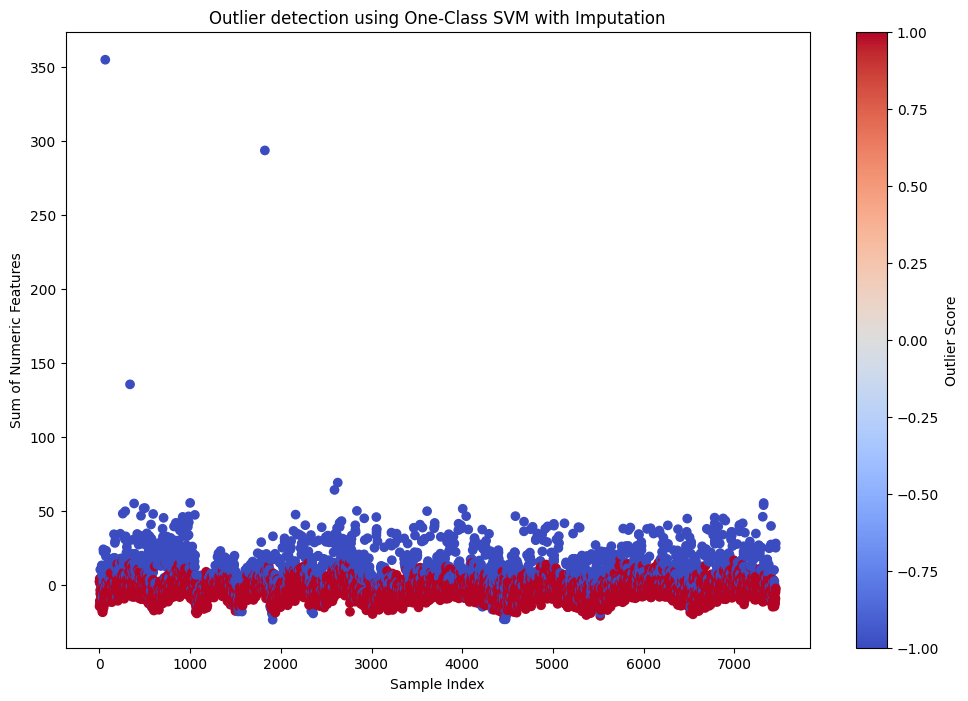

In [26]:
# Prepare the data
X = QuebrasFinal[colunas_numericas].values


# Initialize One-Class SVM with desired parameters
ocsvm = OneClassSVM(nu=0.25, gamma='auto')

# Create a pipeline to impute missing values and fit the One-Class SVM model
pipeline = Pipeline([('imputer', imputer_mice), ('ocsvm', ocsvm)])

# Fit the pipeline
pipeline.fit(X)

# Predict outliers
outliers = pipeline.predict(X)

# Visualize the results
plt.figure(figsize=(12, 8))
plt.scatter(range(len(X)), np.sum(X, axis=1), c=outliers, cmap=plt.cm.coolwarm)
plt.xlabel('Sample Index')
plt.ylabel('Sum of Numeric Features')
plt.title('Outlier detection using One-Class SVM with Imputation')
plt.colorbar(label='Outlier Score')
plt.show()


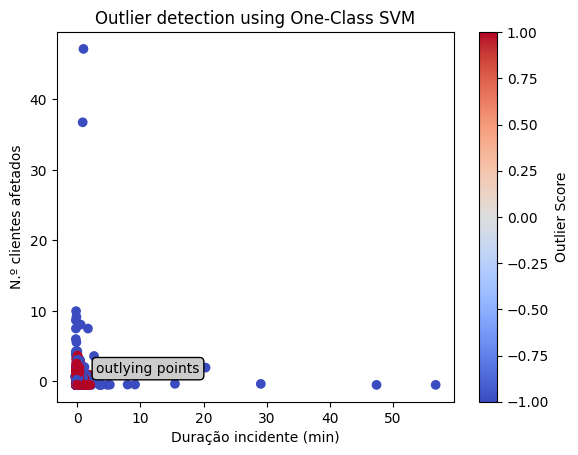

In [27]:
# Prepare the data
X = QuebrasFinal[colunas_numericas].values

# Initialize One-Class SVM with desired parameters
ocsvm = OneClassSVM(nu=0.25, gamma='auto')

# Fit the One-Class SVM model
ocsvm.fit(X)

# Predict outliers
outliers = ocsvm.predict(X)

# Visualize the results
plt.scatter(X[:, 0], X[:, 1], c=outliers, cmap=plt.cm.coolwarm)
plt.xlabel(colunas_numericas[0])
plt.ylabel(colunas_numericas[1])
plt.title('Outlier detection using One-Class SVM')
plt.colorbar(label='Outlier Score')
plt.annotate(
    "outlying points",
    xy=(4, 2),
    xycoords="data",
    textcoords="data",
    xytext=(3, 1.25),
    bbox=dict(boxstyle="round", fc="0.8"),
    arrowprops=dict(arrowstyle="->")
)
plt.show()